In [1]:
import casadi as ca
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

# Parameters
$
W = 162,000 lb\\
thrust = 30000 lb\\
S = 2170 ft^2\\
b = 140 ft\\
length = 90 ft\\
I_{yy} = 4.1 e^6 slug-ft^2
$

In [19]:
def eom(x,u):
    S = 2170
    cbar = 17.5
    mass = 5.0e3
    iyy = 4.1e6
    tstat = 6e4
    dtdv = -38
    ze = 2
    CD_CL_s = 0.042
    CL_a = 0.085
    CM_a = -0.022
    CM_de = -0.016 #per degree
    CM_q = 0.16
    CM_adot = -6
    CL_adot = 0.0
    r2d = 57.29578
    GD = 32.17

    #u = ca.SX.sym('u',4)
    thtl = u[0]
    elev = u[1]
    xcg = u[2]
    land = u[3]

    #x = ca.SX.sym('x',6)
    vt = x[0]
    alpha = x[1]
    alpha_deg = r2d*x[1]
    theta = x[2]
    q = x[3]
    h = x[4]
    p = x[5]
    
    r0 = 2.377e-3
    tfac = 1-0.0703e-5 * h
    T = 519*tfac
    T = ca.if_else(h>=35000,390,519*tfac)

    rho = r0 * (tfac**4.14)
    mach = vt/np.sqrt(1.4*1716.3*T)
    qbar = 0.5*rho*vt**2
    cps = 1715 * rho*T
    qs = qbar*S

    coef_V1 = [0.2,0.016,0.05,0,0]
    coef_V2 = [1,0.08,-0.20,0.02,-0.05]
    msg = 'Landing Gear and Flaps?'
    results = ca.if_else(land,coef_V2,coef_V1)
    results[4]
    CL_0 = results[0]
    CD_0 = results[1]
    CM_0 = results[2]
    dcdg = results[3]
    dcmg = results[4]

    thtl = ca.if_else(thtl<0,0,thtl) #select thtl to be greater than 1
    thr = (tstat + vt*dtdv) * thtl
    CL = CL_0 + CL_a*alpha
    CM = dcmg + CM_0 + CM_a*alpha_deg + CM_de * elev + CL*(xcg-0.25)
    CD = dcdg + CD_0 + CD_CL_s*CL**2

    dx = ca.SX.sym('dx',6)
    gam = theta -x[1]
    dx[0] = (thr*ca.cos(alpha)-qs*CD)/mass - GD*ca.sin(gam)
    dx[1] = (-thr*ca.sin(alpha)-qs*CL+mass*(vt*q+GD*ca.cos(gam)))/(mass*vt+qs*CL_adot)
    dx[2] = q;
    D = 0.5*cbar*(CM_q+CM_adot*dx[1])/vt
    dx[3] = (qs*cbar*(CM+D)+thr*ze)/iyy
    dx[4] = vt*ca.sin(gam)

    dx[5] = vt*ca.cos(gam)  # horizontal speed
    return dx

In [21]:
x = ca.SX.sym('x',6)
u = ca.SX.sym('u',4)
f_eom = ca.Function('eom',[x,u],[eom(x,u)],['x','u'],['dx'],{'jit': True})
draw_graph(eom(x,u))

"dot" with args ['-Tpng', '/tmp/tmpjtqv20ig'] returned code: 1

stdout, stderr:
 b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\t\xb9\x00\x00\x08O\x08\x06\x00\x00\x00\xff\xc4\x14\xba\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddyX\xd5e\xe2\xff\xff\xd7\x81#\xa0B\x99\xa2\x08"\xa0\xb8\x0c60\x92\xb9\x85\x1b\xb9\x14\x9af)\xe5d\xa9m\xe6`j\xcbL6\xda:\x8e\x8d6\xed\xa5\x8dT_m\xd1i\xdc\xd2I\xa24\x10\x93\xc45\xf7\x15\xc4@\x04\x15E\x11\x95\xed\x1c\xce\xef\x0f\x7f\xf2\x19\x12\xe4\xa0\xe0\x9b\x03\xcf\xc7uy\x15\xf7y\xdf\xf7\xfdz\xab\xfds\xaeW\xf7m\xb2\xd9l6\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00P\x0b9\x19\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x8aPr\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd4Z\x94\xdc\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb5\x16%7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xadE\xc9\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00PkQr\x03\x00\x00\x00\x

AssertionError: 1

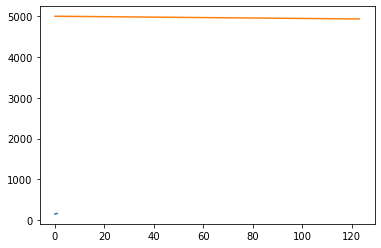

In [15]:
import scipy.integrate
import numpy as np
tf = 1
res = scipy.integrate.solve_ivp(
    fun=lambda t, x: np.array(f_eom(x, [0,0,0,0])).reshape(-1),
    t_span=[0, tf],
    y0=[150,,0,0,5000,0],
    t_eval=np.arange(0, tf, 0.1))
plt.plot(res['t'], res['y'][0, :]);
plt.plot(res['y'][5,:],res['y'][4,:])